In [1]:
import numpy as np
import pandas as pd
import comonotonic as cm
import naiveBayes as nb
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import copy
import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
year = 2014
filename = "cleaned_" + str(year) + "_Financial_Data.csv"
random_state = 24
df = pd.read_csv("Datasets/US_stock/"+filename)
df.rename(columns={'Unnamed: 0': 'Company'}, inplace = True)
shuffled_df = shuffle(df)

In [3]:
shuffled_df = shuffled_df.drop(['Company', str(year+1)+' PRICE VAR [%]', 'operatingCycle', 'cashConversionCycle'], axis = 1)
# drop the constant columns if exist 
for col in shuffled_df.columns:
    if len(shuffled_df[col].unique()) == 1:
        shuffled_df.drop(col,inplace=True,axis=1)

In [4]:
real_colnames = list(shuffled_df.columns.values)
colnames = [('X'+str(i)) for i in range(shuffled_df.shape[1]-1)]
colnames.append('Y')
colname_checker = {colnames[i]:real_colnames[i] for i in range(len(colnames))}
shuffled_df.columns = colnames

In [5]:
encoded_df = utils.encode_df(shuffled_df, [218])
encoded_df = encoded_df.astype({'X218': 'int32'})
cont_col = [i for i in range(218)]
unrankable = [218]

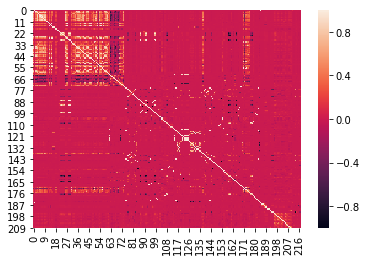

In [6]:
test_df = encoded_df.drop(['X218','Y'], axis = 1)
heat_map_X = test_df.to_numpy()
corr = np.corrcoef(heat_map_X.T)
ax = sns.heatmap(corr)

In [7]:
# replace the extreme values, too small? replace by 5% quantile value; too large? replace by 95% quantile value
inf = encoded_df[colnames[:-2]].quantile(0.05, axis = 0)
sup = encoded_df[colnames[:-2]].quantile(0.95, axis = 0)
for i in range(encoded_df.shape[1]-2):
    col = 'X'+str(i)
    encoded_df[col] = np.where((encoded_df[col] < inf[i]), inf[i], encoded_df[col])
    encoded_df[col] = np.where((encoded_df[col] > sup[i]), sup[i], encoded_df[col])

In [22]:
# clustered comonotonic
df_for_cluster = encoded_df.copy()
clus_X = df_for_cluster[colnames[:-1]].to_numpy()
clus_Y = df_for_cluster[colnames[-1]].to_numpy()
clus_X_train, clus_X_test, clus_Y_train, clus_Y_test = train_test_split(clus_X, clus_Y, test_size=0.2, random_state=random_state)
feature_val = {k:8 for k in range(218)}
feature_val[218] = 11

# auto_discrete is True means that we pass in the original data rather than discretized data
clus_classifier = cm.clustered_comonotonic(clus_X_train, clus_Y_train, {218:11}, cont_col, unrankable,
                                           0.5, random_state)
clus_classifier.run_cluster()


In [23]:
Y_cluster_pred = clus_classifier.cluster_predict(clus_X_test)
utils.get_accuracy(Y_cluster_pred, clus_Y_test)

0.5761154855643045

In [13]:
from sklearn.metrics import classification_report
report = classification_report(clus_Y_test, Y_cluster_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       438
           1       0.53      0.62      0.57       324

    accuracy                           0.60       762
   macro avg       0.60      0.60      0.60       762
weighted avg       0.61      0.60      0.60       762



In [10]:
# implementation of NB from scratch
nb_X = encoded_df[colnames[:-1]].to_numpy()
nb_Y = encoded_df[colnames[-1]].to_numpy()
nb_X_train, nb_X_test, nb_Y_train, nb_Y_test = train_test_split(nb_X, nb_Y, test_size=0.2, random_state=random_state)

nb_classifier = nb.naive_bayes(nb_X_train, nb_Y_train, cont_col)
nb_classifier.run()
nb_y_predict = nb_classifier.predict(nb_X_test)
utils.get_accuracy(nb_y_predict, nb_Y_test)

0.6167979002624672

In [14]:
report_nb = classification_report(nb_Y_test, nb_y_predict)
print(report_nb)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71       438
           1       0.59      0.32      0.42       324

    accuracy                           0.62       762
   macro avg       0.61      0.58      0.57       762
weighted avg       0.61      0.62      0.59       762



In [11]:
# weighted average of naive bayes and cluster comonotonic
weighted_predict_y = []
for i in range(len(clus_X_test)):
    prob_dist_cluster_como = clus_classifier.get_cluster_prob_dist_single(clus_X_test[i])
    predicted_class, prob_dist_nb = nb_classifier.predict_single(nb_X_test[i])
    print(prob_dist_cluster_como)
    print(prob_dist_nb)
    print("-------")
    weighted_predict_y.append(utils.weighted_avg(prob_dist_nb, prob_dist_cluster_como, 0.7))

print(utils.get_accuracy(weighted_predict_y, clus_Y_test))

{0: 0.8693227469428757, 1: 0.13067725305712433}
{0: 0.9999994474051761, 1: 5.525948239215344e-07}
-------
{0: -0.005473205018577753, 1: 1.0054732050185777}
{0: 9.588295603899752e-23, 1: 1.0}
-------
{0: 0.8149183440478763, 1: 0.18508165595212367}
{0: 0.9998868420006155, 1: 0.00011315799938443794}
-------
{0: 1.0763353517036403, 1: -0.07633535170364018}
{0: 0.999999620764483, 1: 3.7923551702433953e-07}
-------
{0: -0.035824375064355776, 1: 1.0358243750643557}
{0: 0.9898848264349929, 1: 0.010115173565007162}
-------
{0: 1.2671122278590894, 1: -0.26711222785908945}
{0: 0.9999511875697372, 1: 4.881243026286333e-05}
-------
{0: -1.716689815515478e-05, 1: 1.000017166898155}
{0: 1.712723648020906e-17, 1: 1.0}
-------
{0: 1.021002834136676, 1: -0.021002834136675936}
{0: 0.9999999866936782, 1: 1.330632176832675e-08}
-------
{0: 0.01054513110515854, 1: 0.9894548688948415}
{0: 0.5953075070242769, 1: 0.404692492975723}
-------
{0: 1.022879065297584, 1: -0.02287906529758406}
{0: 0.999987061178633, 

{0: 0.9774955287161206, 1: 0.022504471283879356}
{0: 0.9999999999937678, 1: 6.2323628627235916e-12}
-------
{0: 5.728091094480378, 1: -4.728091094480378}
{0: 0.9884054937700875, 1: 0.011594506229912644}
-------
{0: -0.003263995078523805, 1: 1.0032639950785238}
{0: 2.9387107181979682e-15, 1: 0.999999999999997}
-------
{0: 1.0360513466243644, 1: -0.03605134662436439}
{0: 0.9991578313170405, 1: 0.0008421686829594838}
-------
{0: 0.0, 1: 1.0}
{0: 0.9999999999952975, 1: 4.702506604996479e-12}
-------
{0: 1.1477587437025163, 1: -0.14775874370251615}
{0: 0.9999999999983981, 1: 1.6018248384774523e-12}
-------
{0: 0.9635933782120446, 1: 0.036406621787955305}
{0: 0.9989144584353198, 1: 0.0010855415646802917}
-------
{0: -0.02349389142210837, 1: 1.0234938914221083}
{0: 3.9491111812742494e-19, 1: 1.0}
-------
{0: 0.13978871914377494, 1: 0.860211280856225}
{0: 0.6457415577116801, 1: 0.3542584422883198}
-------
{0: 0.5636616711100582, 1: 0.43633832888994195}
{0: 0.9999360239564736, 1: 6.397604352632

{0: 1.1428189828586766, 1: -0.14281898285867656}
{0: 0.9999998743936268, 1: 1.2560637323346983e-07}
-------
{0: -0.08607048023135395, 1: 1.086070480231354}
{0: 5.369998339442751e-21, 1: 1.0}
-------
{0: 0.0009365679520386208, 1: 0.9990634320479613}
{0: 0.855824859999009, 1: 0.14417514000099096}
-------
{0: 0.16526801491181034, 1: 0.8347319850881896}
{0: 0.9911115308345083, 1: 0.008888469165491696}
-------
{0: 0.2782814109669234, 1: 0.7217185890330765}
{0: 0.9999999999899287, 1: 1.0071312770804052e-11}
-------
{0: 6.081209744626652, 1: -5.081209744626652}
{0: 0.9999999999342133, 1: 6.578677150902324e-11}
-------
{0: -2.2960324863718307, 1: 3.2960324863718307}
{0: 0.9994168884545159, 1: 0.0005831115454840351}
-------
{0: -2.4164938239689318, 1: 3.4164938239689318}
{0: 0.9999262269502748, 1: 7.377304972517808e-05}
-------
{0: 2.065406745450692, 1: -1.0654067454506921}
{0: 0.9991149118142094, 1: 0.0008850881857905558}
-------
{0: 0.04927883053437416, 1: 0.9507211694656258}
{0: 0.9999940910

{0: 0.9101500823548744, 1: 0.08984991764512563}
{0: 0.47129465328281084, 1: 0.5287053467171892}
-------
{0: 0.957996614917949, 1: 0.04200338508205098}
{0: 0.9997284789008671, 1: 0.0002715210991329215}
-------
{0: 0.9998970511815773, 1: 0.0001029488184226323}
{0: 0.9999998095815269, 1: 1.9041847306705243e-07}
-------
{0: 0.9885015992003351, 1: 0.011498400799664979}
{0: 0.99999995286435, 1: 4.7135650041109864e-08}
-------
{0: -0.010214730447777822, 1: 1.0102147304477778}
{0: 2.515744255872532e-19, 1: 1.0}
-------
{0: 3.081063210206002, 1: -2.081063210206002}
{0: 0.9999517038297179, 1: 4.829617028206619e-05}
-------
{0: 0.27047383798952435, 1: 0.7295261620104757}
{0: 0.9802357299688945, 1: 0.01976427003110554}
-------
{0: 0.007267904533352498, 1: 0.9927320954666475}
{0: 1.9623705083122028e-15, 1: 0.9999999999999979}
-------
{0: 0.011206369206388737, 1: 0.9887936307936113}
{0: 0.8299495473316923, 1: 0.17005045266830765}
-------
{0: 0.5527136483865146, 1: 0.44728635161348534}
{0: 0.99937121

{0: 1.0167055288081366, 1: -0.01670552880813641}
{0: 0.9881341708697498, 1: 0.011865829130250178}
-------
{0: 1.0270505573436006, 1: -0.027050557343600668}
{0: 0.9999999945534, 1: 5.446599974822071e-09}
-------
{0: 0.9992371830801958, 1: 0.0007628169198041541}
{0: 0.9999999997188325, 1: 2.811675322484671e-10}
-------
{0: 0.9906311773472612, 1: 0.009368822652738727}
{0: 0.9998128819919796, 1: 0.0001871180080203509}
-------
{0: 2.274441670798983, 1: -1.2744416707989832}
{0: 0.9995226191340798, 1: 0.0004773808659202843}
-------
{0: 1.000163817397122, 1: -0.00016381739712200834}
{0: 0.9999999999621453, 1: 3.785465246527038e-11}
-------
{0: -0.8194236526561038, 1: 1.8194236526561038}
{0: 0.9806141489663588, 1: 0.019385851033641172}
-------
{0: 0.12172750822498926, 1: 0.8782724917750107}
{0: 0.13015769981300618, 1: 0.8698423001869938}
-------
{0: 0.5894079482781016, 1: 0.4105920517218984}
{0: 0.9999998804977808, 1: 1.1950221924955733e-07}
-------
{0: -0.16784924187120276, 1: 1.16784924187120

{0: -0.23691821818571682, 1: 1.2369182181857168}
{0: 0.9685143444305465, 1: 0.03148565556945344}
-------
{0: 1.0, 1: 0.0}
{0: 0.9983945250147972, 1: 0.001605474985202712}
-------
{0: 0.9982995124262295, 1: 0.0017004875737704562}
{0: 0.999999999735049, 1: 2.649508850439624e-10}
-------
{0: -0.0, 1: 1.0}
{0: 0.9568784073141585, 1: 0.04312159268584154}
-------
{0: -0.00029558243819528785, 1: 1.0002955824381952}
{0: 1.152099873694199e-20, 1: 1.0}
-------
{0: 0.9969006971661897, 1: 0.003099302833810337}
{0: 0.9999995658610735, 1: 4.3413892652698114e-07}
-------
{0: 1.0354565990402225, 1: -0.03545659904022251}
{0: 0.9999432654274615, 1: 5.6734572538464246e-05}
-------
{0: -0.0002667598051052847, 1: 1.0002667598051054}
{0: 2.4553254216839378e-20, 1: 1.0}
-------
{0: 0.9684579324776607, 1: 0.03154206752233941}
{0: 0.9999999999972784, 1: 2.721686082110032e-12}
-------
{0: -1.1271998886888763, 1: 2.1271998886888763}
{0: 2.0310130434372393e-16, 1: 0.9999999999999998}
-------
{0: 0.999999999999999

{0: 1.2634828552836077, 1: -0.26348285528360776}
{0: 0.9939807449188104, 1: 0.006019255081189587}
-------
{0: -0.1091672584520225, 1: 1.1091672584520225}
{0: 0.9904560949071567, 1: 0.009543905092843238}
-------
{0: 0.9873799920030301, 1: 0.012620007996969987}
{0: 0.999991001923007, 1: 8.998076992872079e-06}
-------
{0: -0.0003359388658592691, 1: 1.0003359388658593}
{0: 0.03245600690217822, 1: 0.9675439930978217}
-------
{0: 0.29651299586916974, 1: 0.7034870041308303}
{0: 0.9999868503507598, 1: 1.3149649240196613e-05}
-------
{0: -0.00014935176856869386, 1: 1.0001493517685687}
{0: 1.0116405858795565e-15, 1: 0.999999999999999}
-------
{0: 0.1064458355428509, 1: 0.8935541644571491}
{0: 0.9990456123899591, 1: 0.0009543876100408104}
-------
{0: 0.956523221023802, 1: 0.043476778976197984}
{0: 0.9999998908961232, 1: 1.0910387686102446e-07}
-------
{0: 0.9992512538781684, 1: 0.000748746121831512}
{0: 0.999991166088157, 1: 8.833911843045669e-06}
-------
{0: -0.0, 1: 1.0}
{0: 9.50438855466018e-1

{0: 1.1510210294388588, 1: -0.15102102943885884}
{0: 0.9999896624026272, 1: 1.0337597372780678e-05}
-------
{0: 7.839808388538588e-05, 1: 0.9999216019161146}
{0: 0.8905864637008767, 1: 0.10941353629912329}
-------
{0: 1.0013834751996478, 1: -0.0013834751996477997}
{0: 0.9999997649166297, 1: 2.3508337044521739e-07}
-------
{0: 4.1936718980716625, 1: -3.193671898071663}
{0: 0.9388188250804663, 1: 0.061181174919533655}
-------
{0: 1.0002505255022773, 1: -0.0002505255022772436}
{0: 0.9996664452004546, 1: 0.00033355479954557695}
-------
{0: 0.42595749444647735, 1: 0.5740425055535227}
{0: 0.9987448232625619, 1: 0.001255176737438106}
-------
{0: 1.0000000000000007, 1: -6.449298379947914e-16}
{0: 0.11119842529515651, 1: 0.8888015747048434}
-------
{0: 0.47155397677965993, 1: 0.5284460232203402}
{0: 2.257639519363112e-20, 1: 1.0}
-------
{0: -0.00028258734346210354, 1: 1.0002825873434622}
{0: 7.575316011895559e-18, 1: 1.0}
-------
{0: 0.007133660922373098, 1: 0.992866339077627}
{0: 3.6807103486

{0: 0.9987336142752278, 1: 0.0012663857247722638}
{0: 0.9999999908472755, 1: 9.152724571466162e-09}
-------
{0: 0.0007535079670627476, 1: 0.9992464920329373}
{0: 1.0757539242499438e-20, 1: 1.0}
-------
{0: 1.0345011697535607, 1: -0.03450116975356062}
{0: 0.9981987586689078, 1: 0.0018012413310921588}
-------
{0: 1.1707729806140585, 1: -0.17077298061405857}
{0: 0.999991701742687, 1: 8.298257312923604e-06}
-------
{0: 3.2838982175532925, 1: -2.2838982175532925}
{0: 0.9999730293217439, 1: 2.69706782561311e-05}
-------
{0: 0.3790069640613267, 1: 0.6209930359386732}
{0: 0.9983852539588441, 1: 0.0016147460411558108}
-------
{0: 1.3452098201646605, 1: -0.3452098201646605}
{0: 0.9989899641072514, 1: 0.0010100358927486591}
-------
{0: 1.061155744314137, 1: -0.061155744314137075}
{0: 0.9999692271655124, 1: 3.0772834487593626e-05}
-------
{0: 0.45371234939424626, 1: 0.5462876506057538}
{0: 0.9999999946044781, 1: 5.395521937991779e-09}
-------
{0: -0.00024907290625635574, 1: 1.0002490729062563}
{0:

{0: 0.9862884422382733, 1: 0.013711557761726766}
{0: 0.9999999967441878, 1: 3.2558121545101e-09}
-------
{0: 0.9104994750397051, 1: 0.08950052496029497}
{0: 0.9999340990740471, 1: 6.590092595278388e-05}
-------
{0: 0.03238900623097369, 1: 0.9676109937690264}
{0: 0.6910694859501479, 1: 0.30893051404985206}
-------
{0: 1.0968959972091996, 1: -0.09689599720919959}
{0: 0.9999999998193451, 1: 1.806549755273732e-10}
-------
{0: 1.9581238118903674, 1: -0.9581238118903674}
{0: 0.9999999296771738, 1: 7.032282616367575e-08}
-------
{0: 1.1001778580596435, 1: -0.10017785805964341}
{0: 0.6298063724257852, 1: 0.37019362757421465}
-------
{0: 0.30324131073548166, 1: 0.6967586892645184}
{0: 0.9689253031301485, 1: 0.031074696869851516}
-------
{0: 0.9916569153334124, 1: 0.008343084666587681}
{0: 0.99999848473227, 1: 1.5152677300114355e-06}
-------
{0: 0.9983475087168174, 1: 0.0016524912831825179}
{0: 0.9998935156002374, 1: 0.00010648439976253817}
-------
{0: 1.1225620816795385, 1: -0.12256208167953851

In [15]:
report_combined = classification_report(clus_Y_test, weighted_predict_y)
print(report_combined)

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       438
           1       0.58      0.38      0.46       324

    accuracy                           0.62       762
   macro avg       0.61      0.59      0.58       762
weighted avg       0.61      0.62      0.60       762



In [24]:
import operator
both_correct = 0
both_wrong = 0
nb_correct = 0
clus_correct = 0
for i in range(len(clus_X_test)):
    prob_dist_cluster_como = clus_classifier.get_cluster_prob_dist_single(clus_X_test[i])
    nb_result, prob_dist_nb = nb_classifier.predict_single(nb_X_test[i])
    clus_result = max(prob_dist_cluster_como.items(), key=operator.itemgetter(1))[0]
    if str(clus_result) == str(nb_result) == str(clus_Y_test[i]):
        both_correct += 1
    elif (str(clus_result) == str(nb_result)) and (str(nb_result) != str(clus_Y_test[i])):
        both_wrong += 1
    elif (str(clus_result) != str(nb_result)) and (str(nb_result) == str(clus_Y_test[i])):
        nb_correct += 1
    elif (str(clus_result) != str(nb_result)) and (str(clus_result) == str(clus_Y_test[i])):
        clus_correct += 1

In [25]:
print("Both Correct: " + str(both_correct/len(clus_X_test)))
print("Both Wrong: " + str(both_wrong/len(clus_X_test)))
print("nb Correct: " + str(nb_correct/len(clus_X_test)))
print("clus Correct: " + str(clus_correct/len(clus_X_test)))

Both Correct: 0.46194225721784776
Both Wrong: 0.2440944881889764
nb Correct: 0.15485564304461943
clus Correct: 0.13910761154855644
